# Problem 14: Head-Dependent Boundary Conditions

## INTRODUCTION
The RIVER, DRAIN, GENERAL HEAD, and EVAPOTRANSPIRATION packages of MODFLOW are all head-dependent flux or third type boundary conditions. Although their names imply specific types of sources or sinks, these packages are mathematically very similar and can be used for a variety of hydrologic conditions other than those their names suggest. This exercise illustrates the similarity of the packages, compares results of each to one another as a verification, and gives insight to the utility of parameters used in the packages.


## PROBLEM STATEMENT AND DATA
In order to evaluate these boundary conditions, a single layer, 7 node by 7 node unconfined aquifer is modeled in parts a-d. All cells in the domain are active and a well pumps in the upper left-hand comer (node 1,1). A head-dependent flux boundary condition runs along column 4 for the entire length of the system. The boundary will be treated in five different ways in this exercise. Details on the model specific to all configurations are given in Table 14.1.


### Part d)
Model the third type boundary condition as a line of ET nodes running down column 4. These nodes will have the following characteristics:

| Variable             | Value    |
|----------------------|----------|
| Maximum ET rate      | 0.2 ft/d |
| Extinction depth     | 10 ft    |
| ET surface elevation | 10 ft    |
| Boundary             | column 4 |

Run the model and note the results as you did in parts a-c. You will need to store the cell-by-cell ET rates for each time step and then run POSTMOD to put into an ASCII form.


###  Table 14.1. Aquifer parameters and discretization data for Problem 14
| Variable                     | Value       |
|------------------------------|-------------|
| Initial head                 | 10 ft       |
| Hydraulic conductivity       | 10 ft/d     |
| Aquifer base                 | -50 ft      |
| Storage coefficient          | 0.1         |
| Grid spacing (uniform)       | 100 ft      |
| Pumping rate                 | 2500 ft^2/d |
| Stress period length         | 365 days    |
| Time steps                   | 20          |
| Time step multiplier         | 1.2         |
| SIP iteration parameters     | 5           |
| Maximum number of iterations | 50          |
| Acceleration parameter       | 1           |
| Closure criterion            | 0.001       |

In [32]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
#import csv

In [33]:
print(os.getcwd())
delr = [] #creates an empty list
f = open('../Data/table14.1.csv') #opens the csv file; the two periods (.) means that you are goin backwards into the folders.
    
    #the four loop below creates a statement that if i == 0 (if it's the first
    #row then it will skip it (continue) and move on with the for loop)
    #we skip the first row in our table/csv file because the headers would give
    #us an error since they aren't numerical values.
for i,line in enumerate(f):
    if i == 0: 
        continue
        
    #"line.strip" gets rid of any extra spaces in the margins of the plot
    #"split" sections of the individual values according to whatever you put in the quotes
    linelist = line.strip().split(',') 
    
    value = float(linelist[1]) #changes the values in the list to floats
    print(value) #prints the values
    delr.append(value) #puts the floats into the empty list, delr 
    
print(delr) #prints the list

C:\VT\USGS Internship\EPA-MF-Problems\Notebooks
10.0
10.0
-50.0
0.1
100.0
2500.0
365.0
20.0
1.2
5.0
50.0
1.0
0.001
[10.0, 10.0, -50.0, 0.1, 100.0, 2500.0, 365.0, 20.0, 1.2, 5.0, 50.0, 1.0, 0.001]


In [34]:
#Store the values of each parameter into separate variables
inh = 10.0 #initial head
hk = 10.0 #hydraulic conductivity
botm = -50.0 #aquifer base
sy = 0.1 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -2500. #pumping rate
perlen = 365 #final time (stress period length)
nstp = 20 #number of time steps
tsmult = 1.2 #time step multiplier
sip_it_par = 5 #SIP iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
nlay = 1 #number of layers
nrow = 7 #number of rows
ncol = 7 #number of columns

#print values to make sure they are all stored properly
#put in quotes to make a string, .format takes whatever is in the () 
#and changes it to a float, it is then stored in the {}

print('initial head: {} ft'.format(inh))
print('hydraulic conductivity: {} ft/d'.format(hk))
print('aquifer base: {} ft'.format(botm))
print('storage coefficient: {}'.format(sy))
print('grid spacing (uniform): {} ft'.format(delr))
print('pumping rate: {} ft^3/d'.format(pr))
print('stress period length: {} days'.format(perlen))
print('number of time steps: {}'.format(nstp))
print('time step expansion factor: {}'.format(tsmult))
print('SIP iteration parameters: {}'.format(sip_it_par))
print('maximum number of iterations: {}'.format(mxiter))
print('accelereation parameter: {}'.format(accel_par))
print('closure criterion: {}'.format(hclose))


initial head: 10.0 ft
hydraulic conductivity: 10.0 ft/d
aquifer base: -50.0 ft
storage coefficient: 0.1
grid spacing (uniform): 100 ft
pumping rate: -2500.0 ft^3/d
stress period length: 365 days
number of time steps: 20
time step expansion factor: 1.2
SIP iteration parameters: 5
maximum number of iterations: 50
accelereation parameter: 1.0
closure criterion: 0.001


In [35]:
#Flopy objects
modelname = 'p14_pd' #short for problem 14 part d
exe_name = '../MF2005.1_12/bin/mf2005.exe'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = modelname)

In [36]:
#call in the discretization package
top = 10 #an array of the top elevation of layer 1
nper = 1 #number of periods
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

In [37]:
#call in the basic package
ibound = np.ones((nlay, nrow, ncol))
strt = 10
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [38]:
#call in the layer-propery flow (LPF)
laytyp = 1
ipakcb = 50
lpf = flopy.modflow.ModflowLpf(mf, ipakcb=ipakcb, hk=hk, sy=sy, laytyp=laytyp)

In [39]:
#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 0, 0, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)


In [40]:
#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

In [41]:
#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 
                                                              'print head', 'save budget']})

In [42]:
#call in evapotranspiration package (EVT)
surf = 10
exdp = 10

#evtr = .2
#evtr = np.arange(49)
#evtr.shape = (7, 7)
#print(evtr[:, 3])

evtr = np.zeros((7, 7))
evtr[:, 3] = 0.2
print(evtr)

evt = flopy.modflow.ModflowEvt(mf, ipakcb=ipakcb, surf=surf, evtr=evtr, exdp=exdp)

[[ 0.   0.   0.   0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0. ]
 [ 0.   0.   0.   0.2  0.   0.   0. ]]


In [43]:
# Write the MODFLOW model input files
mf.write_input()

In [44]:
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p14_pd.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/06/14 11:03:40

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Gro

In [45]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(modelname, 'p14_pd.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
times = headobj.get_times() #assign the headobj values to the variable "times"
print(times) #prints the time at each stress period

#print hydraulic head at node (1, 4) for part a (Table 14.2)
ts = headobj.get_ts([[0, 0, 3]])
print(ts)

[1.9551325, 4.3012915, 7.1166821, 10.495152, 14.549314, 19.41431, 25.252306, 32.2579, 40.664616, 50.752674, 62.858345, 77.385147, 94.817314, 115.73592, 140.83824, 170.96103, 207.10838, 250.4852, 302.53738, 365.0]
[[  1.95513248e+00   8.51035500e+00]
 [  4.30129147e+00   7.53955841e+00]
 [  7.11668205e+00   6.71613359e+00]
 [  1.04951515e+01   5.92555618e+00]
 [  1.45493145e+01   5.12856054e+00]
 [  1.94143105e+01   4.31294441e+00]
 [  2.52523060e+01   3.48044372e+00]
 [  3.22579002e+01   2.64200115e+00]
 [  4.06646156e+01   1.81514454e+00]
 [  5.07526741e+01   1.02176082e+00]
 [  6.28583450e+01   2.85528183e-01]
 [  7.73851471e+01  -4.96096998e-01]
 [  9.48173141e+01  -1.44187021e+00]
 [  1.15735916e+02  -2.54352784e+00]
 [  1.40838242e+02  -3.84708095e+00]
 [  1.70961029e+02  -5.40446758e+00]
 [  2.07108383e+02  -7.27203703e+00]
 [  2.50485199e+02  -9.51442719e+00]
 [  3.02537384e+02  -1.22083511e+01]
 [  3.65000000e+02  -1.54460287e+01]]


In [46]:
import pandas as pd
table2d = pd.read_csv('../Data/table14.2.csv')

table2d.columns #displays all the column names in the file
#drops the columns that you enter into the list
table2d.drop(['River (part a)', 'GHB (part b)', 'Drain (part c)', 'Constant head (part e)'], 
             axis=1, inplace=True)
#prints out the first 5 rows into a table
table2d.head()

,Time Step,Ellapsed Time (days),E-T (part d)
0,1,1.955,8.510
1,2,4.301,7.540
2,3,70117.000,6.716
3,4,10.495,5.926
4,5,14.549,5.129


In [47]:
print(table2d)

    Time Step  Ellapsed Time (days)  E-T (part d)
0           1                 1.955         8.510
1           2                 4.301         7.540
2           3             70117.000         6.716
3           4                10.495         5.926
4           5                14.549         5.129
5           6                19.414         4.313
6           7                25.252         3.481
7           8                32.258         2.643
8           9                40.655         1.816
9          10                50.753         1.023
10         11                62.858         0.286
11         12                77.385        -0.495
12         13                94.817        -1.440
13         14               115.740        -2.540
14         15               140.840        -3.843
15         16               170.960        -5.399
16         17               207.110        -7.264
17         18               250.490        -9.505
18         19               302.540       -12.200


### Table 14.2. Hydraulic head at node (1,4) for part d representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | E-T (part d) |
|-----------|---------------------|--------------|
| 1         | 1.955               | 8.51         |
| 2         | 4.301               | 7.54         |
| 3         | 7.117               | 6.716        |
| 4         | 10.495              | 5.926        |
| 5         | 14.549              | 5.129        |
| 6         | 19.414              | 4.313        |
| 7         | 25.252              | 3.481        |
| 8         | 32.258              | 2.643        |
| 9         | 40.655              | 1.816        |
| 10        | 50.753              | 1.023        |
| 11        | 62.858              | 0.286        |
| 12        | 77.385              | -0.495       |
| 13        | 94.817              | -1.44        |
| 14        | 115.74              | -2.54        |
| 15        | 140.84              | -3.843       |
| 16        | 170.96              | -5.399       |
| 17        | 207.11              | -7.264       |
| 18        | 250.49              | -9.505       |
| 19        | 302.54              | -12.2        |
| 20        | 365                 | -15.43       |

In [48]:
#print discharge values (Table 14.3)
fname = os.path.join(modelname, 'p14_pd.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
cbb.list_records()

(1, 1, b'         STORAGE', 7, 7, -1, 1, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'   CONSTANT HEAD', 7, 7, -1, 2, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'FLOW RIGHT FACE ', 7, 7, -1, 1, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'FLOW FRONT FACE ', 7, 7, -1, 1, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'              ET', 7, 7, -1, 3, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(2, 1, b'         STORAGE', 7, 7, -1, 1, 2.346158981323242, 4.301291465759277, 4.301291465759277, b'', b'', b'', b'')
(2, 1, b'   CONSTANT HEAD', 7, 7, -1, 2, 2.346158981323242, 4.301291465759277, 4.301291465759277, b'', b'', b'', b'')
(2, 1, b'FLOW RIGHT FACE ', 7, 7, -1, 1, 2.346158981323242, 4.301291465759277, 4.301291465759277, b'', b'', b'', b'')
(2, 1, b'FLOW FRONT FACE ', 7, 7, -1, 1, 

In [49]:
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
et_flow = cbb.get_data(text='ET')

In [50]:
#create for loop to store only the first value of each time step from riv_flow into riv_list
for et in et_flow:
    print(et[1])

[[    0.             0.             0.         -1702.07104492     0.             0.
      0.        ]
 [    0.             0.             0.         -1706.33959961     0.             0.
      0.        ]
 [    0.             0.             0.         -1710.51403809     0.             0.
      0.        ]
 [    0.             0.             0.         -1713.21191406     0.             0.
      0.        ]
 [    0.             0.             0.         -1714.65515137     0.             0.
      0.        ]
 [    0.             0.             0.         -1715.33605957     0.             0.
      0.        ]
 [    0.             0.             0.         -1715.59790039     0.             0.
      0.        ]]
[[    0.             0.             0.         -1507.91162109     0.             0.
      0.        ]
 [    0.             0.             0.         -1518.23815918     0.             0.
      0.        ]
 [    0.             0.             0.         -1529.73205566     0.             

In [51]:
import pandas as pd
table3d = pd.read_csv('../Data/table14.3.csv')

table3d.columns #displays all the column names in the file
#drops the columns that you enter into the list
table3d.drop(['River (part a)', 'GHB (part b)',
       'Drain (part c)', 'Constant head (part e)'], axis=1, inplace=True)
#prints out the first 5 rows into a table
table3d.head()

,Time Step,Elapsed Time (days),E-T (part d)
0,1,1.955,-1702.071
1,2,4.301,-1507.910
2,3,7.117,-1343.224
3,4,10.495,-1185.109
4,5,14.549,-1025.712


In [52]:
#prints the whole dataframe instead of just the first 5 rows
print(table3d)

    Time Step  Elapsed Time (days)  E-T (part d)
0           1                1.955     -1702.071
1           2                4.301     -1507.910
2           3                7.117     -1343.224
3           4               10.495     -1185.109
4           5               14.549     -1025.712
5           6               19.414      -862.600
6           7               25.252      -696.128
7           8               32.258      -528.506
8           9               40.655      -363.187
9          10               50.753      -204.534
10         11               62.858       -57.278
11         12               77.385         0.000
12         13               94.817         0.000
13         14              115.740         0.000
14         15              140.840         0.000
15         16              170.960         0.000
16         17              207.110         0.000
17         18              250.490         0.000
18         19              302.540         0.000
19         20       

### Table 14.3. Discharge for part d representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | E-T (part d) |
|-----------|---------------------|--------------|
| 1         | 1.955               | -1702.071    |
| 2         | 4.301               | -1507.91     |
| 3         | 7.117               | -1343.224    |
| 4         | 10.495              | -1185.109    |
| 5         | 14.549              | -1025.712    |
| 6         | 19.414              | -862.6       |
| 7         | 25.252              | -696.128     |
| 8         | 32.258              | -528.506     |
| 9         | 40.655              | -363.187     |
| 10        | 50.753              | -204.534     |
| 11        | 62.858              | -57.278      |
| 12        | 77.385              | 0            |
| 13        | 94.817              | 0            |
| 14        | 115.74              | 0            |
| 15        | 140.84              | 0            |
| 16        | 170.96              | 0            |
| 17        | 207.11              | 0            |
| 18        | 250.49              | 0            |
| 19        | 302.54              | 0            |
| 20        | 365                 | 0            |

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


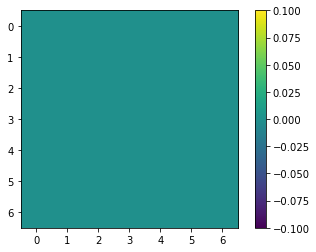

In [53]:
#create a visual representation of data

etsimrate = et[1]
print(etsimrate)
plt.imshow(etsimrate)
plt.colorbar()

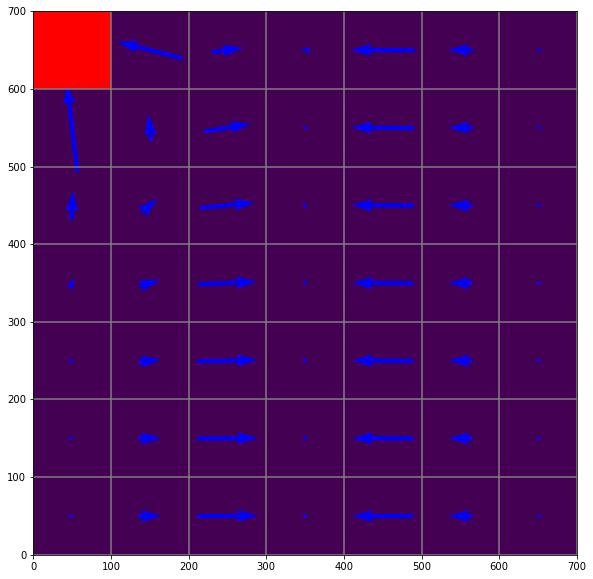

In [54]:
#plot arrows (quivers) that point in the direction of water flowb
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(etsimrate)
quiver = modelmap.plot_discharge(frf, fff, color='b')
linecollection = modelmap.plot_grid()
modelmap.plot_bc("WEL")

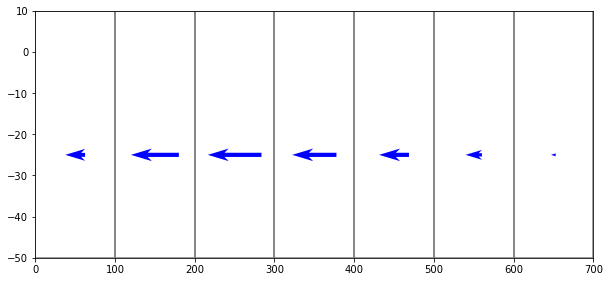

In [55]:
#show plot_array() and plot_discharge()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=mf, ax=ax, line={'Column':6})
#csa = modelxsect.plot_array(etsimrate)
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, hstep=1, normalize=False, color='b', headwidth=3, headaxislength=4) 
patches = modelxsect.plot_ibound()

In [62]:
loadpth = os.path.join('..', 'data', 'freyberg')
modelpth = os.path.join('data')

#make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.makedirs(modelpth)
    
# load the endpoint data
endfile = os.path.join(modelpth, mp.sim.endpoint_file)
endobj = flopy.utils.EndpointFile(endfile)
ept = endobj.get_alldata()

# load the pathline data
#pthfile = os.path.join(modelpth, mpp.sim.pathline_file)
#pthobj = flopy.utils.PathlineFile(pthfile)
#plines = pthobj.get_alldata()

# plot the data
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
#modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
#quadmesh = modelmap.plot_ibound()
#quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
#quiver = modelmap.plot_discharge(frf, fff, head=head)
#linecollection = modelmap.plot_grid()
#for d in ml.wel.stress_period_data[0]:
#    modelmap.plot_endpoint(ept, direction='starting', selection_direction='ending', selection=(d[0], d[1], d[2]), zorder=100)

# construct maximum travel time to plot (200 years - MODFLOW time unit is seconds)
#travel_time_max = 200. * 365.25 * 24. * 60. * 60. 
#ctt = '<={}'.format(travel_time_max)

# plot the pathlines
#modelmap.plot_pathline(plines, layer='all', colors='red', travel_time=ctt);

NameError: name 'mp' is not defined

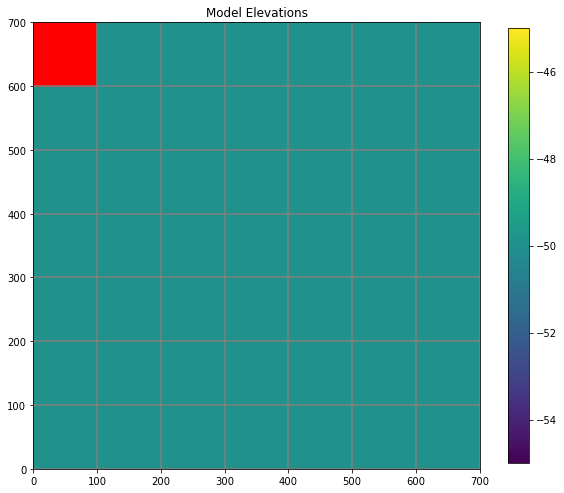

In [56]:
# Plot the model bottom array
a = mf.dis.botm.array

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Elevations')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_array(a)
linecollection = modelmap.plot_grid()
cb = plt.colorbar(quadmesh, shrink=.8)
modelmap.plot_bc("WEL")

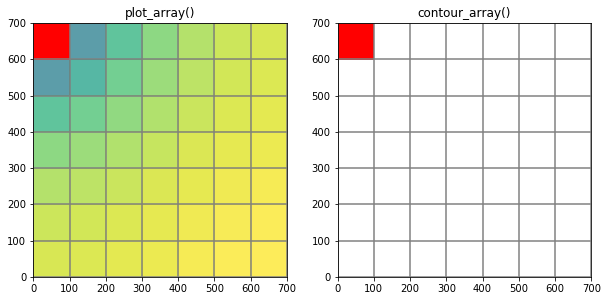

In [57]:
fname = os.path.join(modelname, 'p14_pd.cbc')
#headobj = bf.HeadFile(fname)
#headobj = flopy.utils.HeadFile(fname)
head = headobj.get_data()
levels = np.arange(10, 30, .5)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
linecollection = modelmap.plot_grid()

#contour_array
ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
modelmap.plot_bc("WEL")
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)
linecollection = modelmap.plot_grid()

In [58]:
etlist = []
for kstp in range(20):
    etrate = cbb.get_data(text='ET')[kstp][1]
    etlist.append(etrate[0, 3])
print(etlist)

[-1702.071, -1507.9116, -1343.2268, -1185.1113, -1025.712, -862.58887, -696.08875, -528.40021, -363.02893, -204.35216, -57.10564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


(0, 365.0)

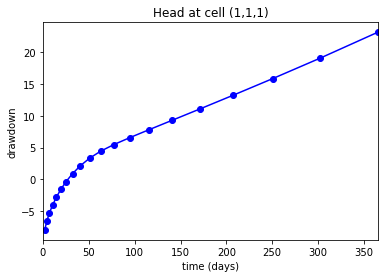

In [59]:
# Plot the drawdown versus time
idx = (0, 0, 0) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 10, 12)*
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())


(0, 365.0)

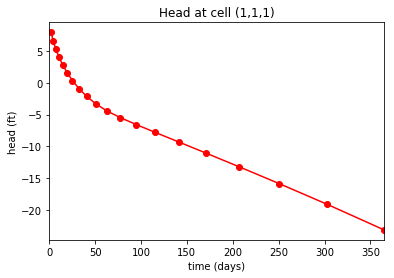

In [60]:
# Plot the head versus time
idx = (0, 0, 0)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())

### Part e)
Model the system described above using a two-layer model. The top layer will be the same as in parts ad, except a third type boundary will not be explicitly included. Instead, the bottom layer will represent the third type boundary condition. The bottom layer will be inactive except along column 4, which will be constant head of 0.0 ft. The bottom layer will be confined and have a transmissivity of 100 ft2/d. Calculate a VCONT between layers 1 and 2 to give a conductance of 200 ft2/d. Run the model and note results as you did in parts a-d.

In [263]:
#print discharge values (Table 14.3)
fname = os.path.join(modelname, 'p14_pc.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
# = cbb.get_data(text='CONSTANT HEAD')[0] #create an array/for loop to get out first value of every step
#cbb.list_records()

#print(fff)
#print()

(1, 1, b'         STORAGE', 7, 7, -1, 1, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'   CONSTANT HEAD', 7, 7, -1, 2, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'FLOW RIGHT FACE ', 7, 7, -1, 1, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'FLOW FRONT FACE ', 7, 7, -1, 1, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(1, 1, b'          DRAINS', 7, 7, -1, 5, 1.9551324844360352, 1.9551324844360352, 1.9551324844360352, b'', b'', b'', b'')
(2, 1, b'         STORAGE', 7, 7, -1, 1, 2.346158981323242, 4.301291465759277, 4.301291465759277, b'', b'', b'', b'')
(2, 1, b'   CONSTANT HEAD', 7, 7, -1, 2, 2.346158981323242, 4.301291465759277, 4.301291465759277, b'', b'', b'', b'')
(2, 1, b'FLOW RIGHT FACE ', 7, 7, -1, 1, 2.346158981323242, 4.301291465759277, 4.301291465759277, b'', b'', b'', b'')
(2, 1, b'FLOW FRONT FACE ', 7, 7, -1, 1, 

### Table 14.2. Hydraulic head at node (1,4) for part e representing the third type boundary condition

Check your results to make sure they match with the table from the book

| Time Step | Elapsed Time (days) | Constant head (part e) |
|-----------|---------------------|------------------------|
| 1         | 1.955               | -1702.071              |
| 2         | 4.301               | -1507.91               |
| 3         | 7.117               | -1343.224              |
| 4         | 10.495              | -1185.109              |
| 5         | 14.549              | -1025.712              |
| 6         | 19.414              | -862.6                 |
| 7         | 25.252              | -696.128               |
| 8         | 32.258              | -528.506               |
| 9         | 40.655              | -363.187               |
| 10        | 50.753              | -204.534               |
| 11        | 62.858              | -57.278                |
| 12        | 77.385              | 74.008                 |
| 13        | 94.817              | 186.017                |
| 14        | 115.74              | 276.478                |
| 15        | 140.84              | 345.343                |
| 16        | 170.96              | 394.331                |
| 17        | 207.11              | 426.631                |
| 18        | 250.49              | 446.21                 |
| 19        | 302.54              | 457.025                |
| 20        | 365                 | 462.099                |

### MODEL RESULT
Table 14.2 shows hydraulic head versus time at node (1,4) for each of the five parts to this problem. Table 14.3 shows discharge versus time at node (1,4). Hydraulic head versus flow is plotted in Figure 14.1.


### Table 14.2. Hydraulic head at node (1,4) for each of the five methods of representing the third type boundary condition

| Time Step | Ellapsed Time (days) | River (part a) | GHB (part b) | Drain (part c) | E-T (part d) | Constant head (part e) |
|-----------|----------------------|----------------|--------------|----------------|--------------|------------------------|
| 1         | 1.955                | 8.51           | 8.51         | 8.51           | 8.51         | 8.51                   |
| 2         | 4.301                | 7.54           | 7.54         | 7.54           | 7.54         | 7.54                   |
| 3         | 70117                | 6.716          | 6.716        | 6.716          | 6.716        | 6.716                  |
| 4         | 10.495               | 5.926          | 5.926        | 5.926          | 5.926        | 5.926                  |
| 5         | 14.549               | 5.129          | 5.129        | 5.129          | 5.129        | 5.129                  |
| 6         | 19.414               | 4.313          | 4.313        | 4.313          | 4.313        | 4.313                  |
| 7         | 25.252               | 3.481          | 3.481        | 3.481          | 3.481        | 3.481                  |
| 8         | 32.258               | 2.643          | 2.643        | 2.643          | 2.643        | 2.643                  |
| 9         | 40.655               | 1.816          | 1.816        | 1.816          | 1.816        | 1.816                  |
| 10        | 50.753               | 1.023          | 1.023        | 1.023          | 1.023        | 1.023                  |
| 11        | 62.858               | 0.286          | 0.286        | 0.286          | 0.286        | 0.286                  |
| 12        | 77.385               | -0.371         | -0.371       | -0.495         | -0.495       | -0.37                  |
| 13        | 94.817               | -0.93          | -0.93        | -1.44          | -1.44        | -0.93                  |
| 14        | 115.74               | -1.382         | -1.382       | -2.54          | -2.54        | -1.382                 |
| 15        | 140.84               | -1.727         | -1.727       | -3.843         | -3.843       | -1.727                 |
| 16        | 170.96               | -1.972         | -1.972       | -5.399         | -5.399       | -1.972                 |
| 17        | 207.11               | -2.175         | -2.133       | -7.264         | -7.264       | -2.133                 |
| 18        | 250.49               | -2.337         | -2.231       | -9.505         | -9.505       | -2.231                 |
| 19        | 302.54               | -2.448         | -2.285       | -12.2          | -12.2        | -2.285                 |
| 20        | 365                  | -2.52          | -2.311       | -15.43         | -15.43       | -2.31

### Table 14.3. Discharge for each of the five methods of representing the third type boundary condition

| Time Step | Elapsed Time (days) | River (part a) | GHB (part b) | Drain (part c) | E-T (part d) | Constant head (part e) |
|-----------|---------------------|----------------|--------------|----------------|--------------|------------------------|
| 1         | 1.955               | -1702.071      | -1702.071    | -1702.071      | -1702.071    | -1702.071              |
| 2         | 4.301               | -1507.91       | -1507.91     | -1507.91       | -1507.91     | -1507.91               |
| 3         | 7.117               | -1343.224      | -1343.224    | -1343.224      | -1343.224    | -1343.224              |
| 4         | 10.495              | -1185.109      | -1185.109    | -1185.109      | -1185.109    | -1185.109              |
| 5         | 14.549              | -1025.712      | -1025.712    | -1025.712      | -1025.712    | -1025.712              |
| 6         | 19.414              | -862.6         | -862.6       | -862.6         | -862.6       | -862.6                 |
| 7         | 25.252              | -696.128       | -696.128     | -696.128       | -696.128     | -696.128               |
| 8         | 32.258              | -528.506       | -528.506     | -528.506       | -528.506     | -528.506               |
| 9         | 40.655              | -363.187       | -363.187     | -363.187       | -363.187     | -363.187               |
| 10        | 50.753              | -204.534       | -204.534     | -204.534       | -204.534     | -204.534               |
| 11        | 62.858              | -57.278        | -57.278      | -57.278        | -57.278      | -57.278                |
| 12        | 77.385              | 74.103         | 74.103       | 0              | 0            | 74.008                 |
| 13        | 94.817              | 186.031        | 186.031      | 0              | 0            | 186.017                |
| 14        | 115.74              | 276.494        | 276.494      | 0              | 0            | 276.478                |
| 15        | 140.84              | 345.353        | 345.353      | 0              | 0            | 345.343                |
| 16        | 170.96              | 394.344        | 394.344      | 0              | 0            | 394.331                |
| 17        | 207.11              | 400            | 426.648      | 0              | 0            | 426.631                |
| 18        | 250.49              | 400            | 446.221      | 0              | 0            | 446.21                 |
| 19        | 302.54              | 400            | 457.037      | 0              | 0            | 457.025                |
| 20        | 365                 | 400            | 462.149      | 0              | 0            | 462.099                |